In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models import *
plt.style.use('ggplot')

In [2]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [3]:
fake_df['title'].str.replace(r"\(.*\)","")
fake_df['title'].str.replace('WATCH:', '')
true_df.text = true_df.text.apply(clean_text)
fake_df['truth'] = 0
true_df['truth'] = 1
all_news_df = pd.concat([fake_df, true_df])
all_news_df.title = all_news_df.title.apply(clean_titles)

In [4]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'title')

In [5]:
from sklearn.decomposition import TruncatedSVD, NMF

In [17]:
nmf_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', NMF(n_components=2))
        ])
W = nmf_clf.fit_transform(X_train)
H = nmf_clf.named_steps.clf.components_

In [18]:
vocab = nmf_clf.named_steps.vect.get_feature_names()

In [19]:
W_df = pd.DataFrame(W, index=X_train)
H_df = pd.DataFrame(H, columns=vocab)

In [20]:
for row in H:
    top_ten = np.argsort(row)[::-1][:20]
    print(np.array(vocab)[top_ten])

['trump' 'obama' 'president' 'hillary' 'clinton' 'donald' 'house' 'just'
 'white' 'new' 'republican' 'campaign' 'news' 'twitter' 'republicans'
 'tax' 'court' 'senate' 'election' 'anti']
['says' 'korea' 'north' 'china' 'russia' 'sanctions' 'south' 'deal'
 'nuclear' 'iran' 'talks' 'eu' 'brexit' 'tillerson' 'korean' 'pm' 'syria'
 'japan' 'missile' 'minister']


In [25]:
top_fake = W_df.iloc[:,0].sort_values(ascending=False).index[:10]
top_real = W_df.iloc[:,1].sort_values(ascending=False).index[:5]
top_fake

Index(['Trump on Twitter  - Trump, Iraq, Syria',
       ' More People Now Support Trump’s Impeachment Than Trump As President',
       'Donald Trump in first full week as U.S. president',
       'What's in tax bill from Trump, House Republicans?',
       ' Paul Ryan Has A Request For Donald Trump, And Trump’s Campaign Won’t Like It AT ALL',
       'Trump on Twitter  - Hillary Clinton, Tax Cut Bill',
       ' Top GOP Adviser Admits Hillary Clinton Would Be A ‘Better President’ Than Donald Trump ',
       'Who’s The Fascist? Barack Obama, Donald Trump or Hillary Clinton?',
       '  Donald Trump Calls For Hillary Clinton To Be SHOT AND KILLED',
       'Trump on Twitter  - Tax Bill'],
      dtype='object')

In [24]:
top_real

Index(['Trump says China 'won't help' with North Korea',
       'Trump says U.S. wants Russia's help on North Korea',
       'South Korea president says China response to North Korea nuclear test key',
       'Trump says will be putting more sanctions on North Korea',
       'Trump says will be putting more sanctions on North Korea'],
      dtype='object')

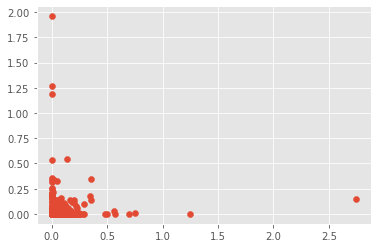

In [14]:
fig, ax = plt.subplots()
ax.scatter(H[0],H[1])
# ax.set_xlim(-.05,.5)

In [17]:
pa_model = passive_aggressive_model(X_train, y_train)
pa_model.score(X_test, y_test)

0.9438265786993403

In [18]:
cv = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2))
counts = cv.fit_transform(X_train).sum(axis=0)
features = cv.get_feature_names()
counts_df = pd.DataFrame(index=features, data=counts.T, columns=['counts'])
counts_df.sort_values('counts', ascending=False, inplace=True)

In [19]:
bag = pa_model.best_estimator_.named_steps.vect.get_feature_names()
pa_coefs = pa_model.best_estimator_.named_steps.clf.coef_
freq_df = pd.DataFrame(index=bag, data={'coefs': pa_coefs[0]})
freq_df = freq_df.iloc[(-freq_df['coefs'].abs()).argsort()]

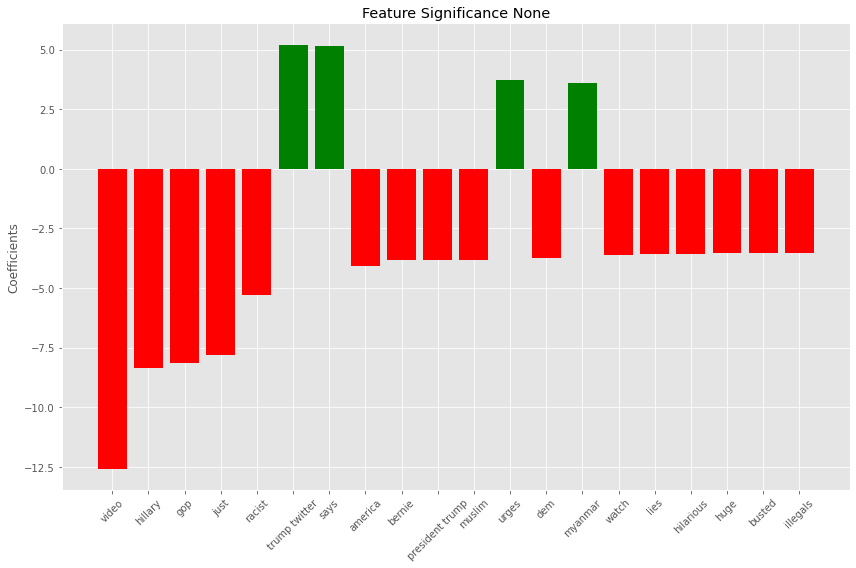

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
def plot_feature_significance(model, fig, ax, col=None):
    bag = model.best_estimator_.named_steps.vect.get_feature_names()
    model_coefs = model.best_estimator_.named_steps.clf.coef_
    freq_df = pd.DataFrame(index=bag, data={'coefs': model_coefs[0]})
    freq_df = freq_df.iloc[(-freq_df['coefs'].abs()).argsort()]
    ax.bar(freq_df.index[:20], freq_df['coefs'][:20].values, color=(freq_df['coefs'][:20] > 0).map({True:'green',False:'red'}))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f'Feature Significance {col}')
    ax.set_ylabel('Coefficients')
    fig.tight_layout()
    # fig.savefig(f'images/feature_correlation_{col}')
plot_feature_significance(pa_model, fig, ax)

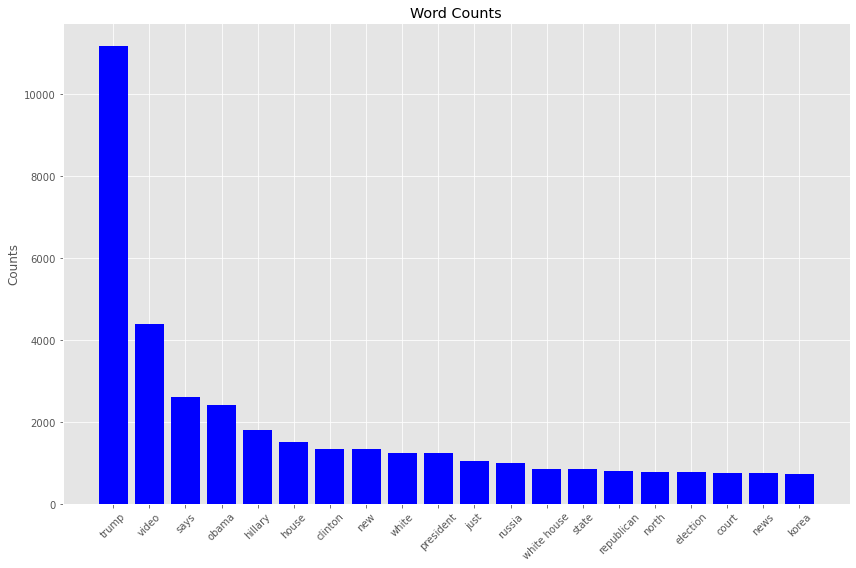

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
def plot_word_counts(X_train, fig, ax, col=None):
    cv = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2))
    counts = cv.fit_transform(X_train).sum(axis=0)
    features = cv.get_feature_names()
    counts_df = pd.DataFrame(index=features, data=counts.T, columns=['counts'])
    counts_df.sort_values('counts', ascending=False, inplace=True)
    ax.bar(counts_df.index[:20], counts_df['counts'][:20].values, color='blue')
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f'Word Counts {col}')
    ax.set_ylabel('Counts')
    fig.tight_layout()
    # fig.savefig(f'images/word_counts_{col}')
plot_word_counts(X_train, fig, ax, col='Title')

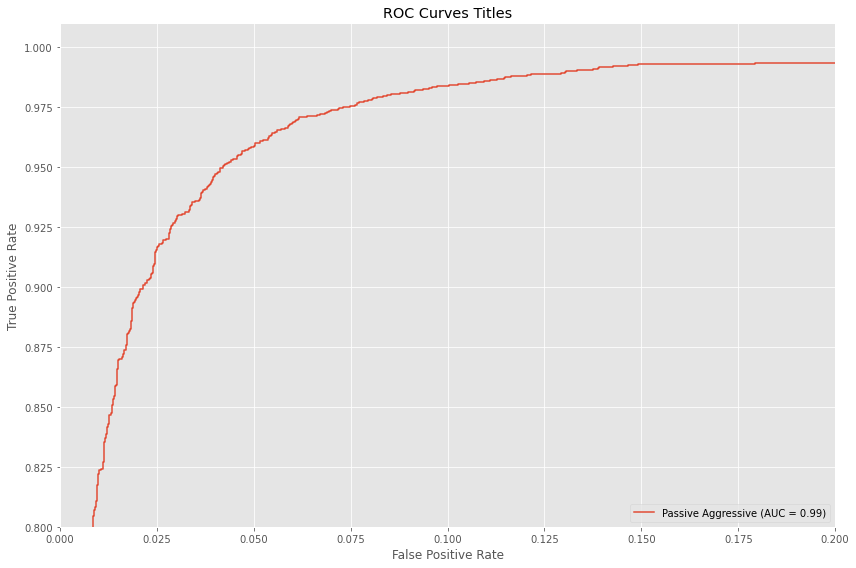

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
models = [pa_model]
titles = ['Passive Aggressive']
def plot_all_roc_curves(models, titles, fig, ax, col=None):
    for model, title in zip(models,titles):
        plot_roc_curve(model, X_test, y_test, name=f'{title}', ax=ax)
    ax.set_ylim(.8,1.01)
    ax.set_xlim(0,.2)
    ax.set_title(f'ROC Curves {col}')
    fig.tight_layout()
    # fig.savefig(f'images/roc_curves_{col}')
plot_all_roc_curves(models, titles, fig, ax, col='Titles')